$$L_{out} = (L_{in} −1)×stride−2×padding+dilation×(kernel size−1)+output padding+1$$

In [6]:
_input = 128
_input = (_input - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + out_padding + 1
_input = _input * 2
_input = (_input - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + out_padding + 1
_input = _input * 2
_input = (_input - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + out_padding + 1
_input = _input * 2
_input

1164

In [1]:
import torch.nn as nn
import torch


In [89]:
class InverseCNNGenerator(nn.Module):
    def __init__(self, 
                 input_size, 
                 label_size, 
                 output_size, 
                 lead_n, 
                 hidden_size, 
                 stride=1, 
                 padding=2, 
                 dilation=2, 
                 kernel_size=7, 
                 out_padding=2,
                 device='cpu'
                ):
        super(InverseCNNGenerator, self).__init__()
        self.input_size = input_size
        self.label_size = label_size
        self.output_size = output_size
        self.lead_n = lead_n
        self.hidden_size = hidden_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.kernel_size = kernel_size
        self.out_padding = out_padding
        self.device = device
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(in_channels=1, 
                               out_channels=self.lead_n * 2,
                               kernel_size=self.kernel_size,
                               stride=self.stride,
                               padding=self.padding,
                               output_padding=self.out_padding,
                               groups=1,
                               dilation=self.dilation,
                              ),
            nn.AvgPool1d(kernel_size=1),
            nn.ConvTranspose1d(in_channels=self.lead_n * 2, 
                               out_channels=self.lead_n * 4,
                               kernel_size=self.kernel_size,
                               stride=self.stride,
                               padding=self.padding,
                               output_padding=self.out_padding,
                               groups=self.lead_n,
                               dilation=self.dilation,
                              ),
            nn.AvgPool1d(kernel_size=1),
            nn.ConvTranspose1d(in_channels=self.lead_n * 4, 
                               out_channels=self.lead_n * 4,
                               kernel_size=self.kernel_size,
                               stride=self.stride,
                               padding=self.padding,
                               output_padding=self.out_padding,
                               groups=self.lead_n,
                               dilation=self.dilation,
                              ),
            nn.AvgPool1d(kernel_size=1),
            nn.ConvTranspose1d(in_channels=self.lead_n * 4, 
                               out_channels=self.lead_n * 2,
                               kernel_size=4,
                               stride=1,
                               padding=3,
                               groups=self.lead_n
                              ),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.lead_n * 2, 
                               out_channels=self.lead_n * 2,
                               kernel_size=4,
                               stride=1,
                               padding=3,
                               groups=self.lead_n
                              ),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.lead_n * 2, 
                               out_channels=self.lead_n,
                               kernel_size=4,
                               stride=2,
                               padding=2,
                               groups=self.lead_n
                              )
        ).to(self.device)
#         gen_out_size = (self.input_size - 1) * self.stride - 2 * self.padding + self.dilation * (self.kernel_size - 1) + self.out_padding + 1
#         gen_out_size *= 2
#         gen_out_size = (gen_out_size - 1) * self.stride - 2 * self.padding + self.dilation * (self.kernel_size - 1) + self.out_padding + 1
#         gen_out_size *= 2
#         gen_out_size = (gen_out_size - 1) * self.stride - 2 * self.padding + self.dilation * (self.kernel_size - 1) + self.out_padding + 1
#         gen_out_size *= 2
#         gen_out_size *= self.lead_n
                
        self.encoder = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(in_features=self.label_size + self.input_size, out_features=self.hidden_size)
        ).to(self.device)
        
    def forward(self, noise, label):
        x = self.encoder(torch.cat([noise, label], dim=1)).unsqueeze(1)     
        return torch.sigmoid(self.deconv(x)).transpose(1,2)
        
        

In [90]:
G = InverseCNNGenerator(input_size=128, 
                        label_size=7,
                        output_size=500, 
                        lead_n=12, 
                        hidden_size=256, 
                        stride=1,
                        padding=2,
                        dilation=2,
                        kernel_size=7,
                        out_padding=1,
                        device="cuda:0"
                       )

In [91]:
noise = torch.rand(8, 128, device="cuda:0")
labels = torch.randint(0,1,(8, 7), device="cuda:0").float()
result = G(noise=noise, label=labels)

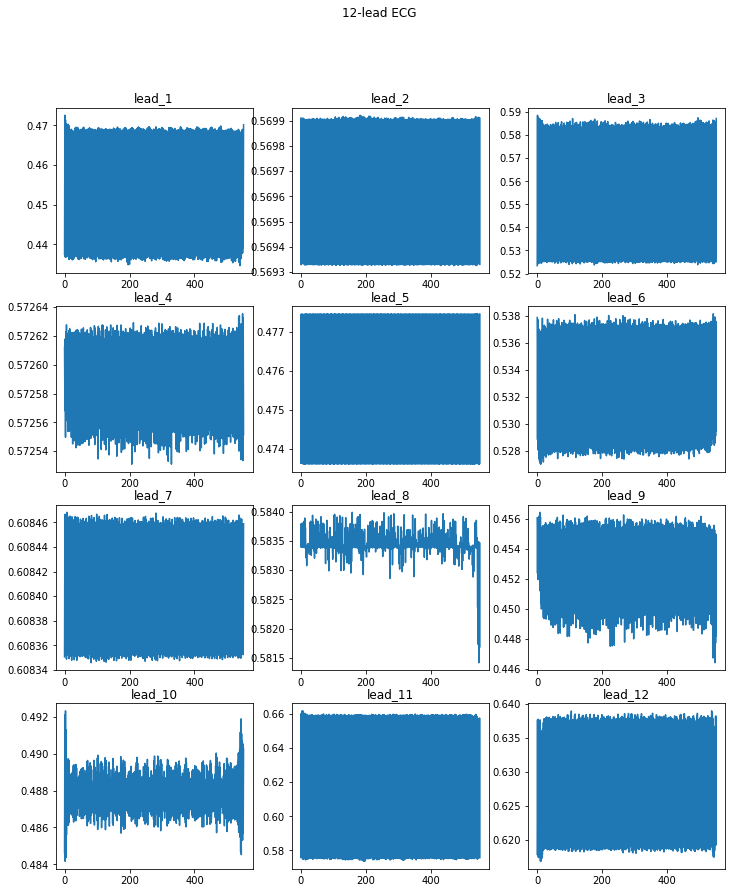

In [93]:
save_ecg_example(result[5].detach().cpu().numpy(), 'tets')

In [79]:
result.shape

torch.Size([8, 552, 12])

In [68]:
from utils.data import save_ecg_example